In [1]:
!pip list

Package                   Version
------------------------- -----------
absl-py                   0.15.0
aiohappyeyeballs          2.4.4
aiohttp                   3.11.10
aiosignal                 1.2.0
anyio                     4.7.0
argon2-cffi               21.3.0
argon2-cffi-bindings      21.2.0
astor                     0.8.1
asttokens                 3.0.0
astunparse                1.6.3
async-lru                 2.0.4
async-timeout             5.0.1
attrs                     24.3.0
babel                     2.16.0
backcall                  0.2.0
beautifulsoup4            4.13.4
bleach                    6.2.0
brotlicffi                1.0.9.2
cachetools                4.2.4
certifi                   2025.7.14
cffi                      1.17.1
charset-normalizer        3.3.2
clang                     5.0
click                     8.1.8
colorama                  0.4.6
comm                      0.2.1
contourpy                 1.3.0
cryptography              41.0.3
cycler            

In [2]:
!pip install tensorflow
!pip install numpy==1.23.5

In [3]:
import os
import cv2
import tensorflow as tf
import numpy as np
import imageio
from typing import List
from matplotlib import pyplot as plt

In [4]:
tf.keras.mixed_precision.set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3050 Laptop GPU, compute capability 8.6


In [5]:
physical_devices = tf.config.list_physical_devices('GPU')

try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU Working")
except:
  pass

GPU Working


## 1. Build Data Loading Functions

In [7]:
import gdown

In [8]:

url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From (original): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=3f3b9598-561a-493a-9248-650a24247e7d
To: D:\Proj\Lip read\data.zip
100%|███████████████████████████████████████████████████████████████████████████████| 423M/423M [00:42<00:00, 10.0MB/s]


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [9]:
def load_video(path:str) -> List[float]: 

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [10]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [11]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [12]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [13]:
char_to_num(['n','i','c','k'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([14,  9,  3, 11], dtype=int64)>

In [14]:
num_to_char([14,  9,  3, 11])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'n', b'i', b'c', b'k'], dtype=object)>

In [15]:
def load_data(path): 
    # Decode if passed as Tensor
    if isinstance(path, tf.Tensor):
        path = path.numpy().decode('utf-8')
    
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data', 's1', f'{file_name}.mpg')
    alignment_path = os.path.join('data', 'alignments', 's1', f'{file_name}.align')
    
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [16]:
def load_alignments(path: str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
        
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens, ' ', line[2]]
    
    # Split into characters and flatten RaggedTensor
    unicode_chars = tf.strings.unicode_split(tokens, input_encoding='UTF-8')
    flat_chars = unicode_chars.flat_values  # now it's a 1D tensor of chars

    return char_to_num(flat_chars)[1:]

In [17]:
test_path = '.\\data\\s1\\bbal6n.mpg'

In [18]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

'bbal6n'

In [19]:
frames, alignments = load_data(test_path)

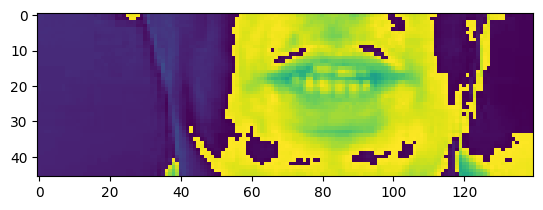

In [20]:
plt.imshow(frames[40])

In [21]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23], dtype=int64)>

In [22]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [23]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

In [24]:
dataset = tf.data.Dataset.from_generator(lambda: gen_data(paths),
                                         (tf.float32, tf.int32))

In [25]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(1, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split 
train = data.take(450)
test = data.skip(450)

In [26]:
len(test)

550

In [27]:
frames, alignments = data.as_numpy_iterator().next()

In [28]:
len(frames)

1

In [29]:
sample = data.as_numpy_iterator()

In [30]:
val = sample.next(); val[0]

array([[[[[1.4640498 ],
          [1.4640498 ],
          [1.4265101 ],
          ...,
          [9.122157  ],
          [0.15015896],
          [0.18769869]],

         [[1.4640498 ],
          [1.4640498 ],
          [1.4265101 ],
          ...,
          [9.122157  ],
          [0.11261922],
          [0.18769869]],

         [[1.3138909 ],
          [1.3138909 ],
          [1.3514307 ],
          ...,
          [0.03753974],
          [0.26277816],
          [0.26277816]],

         ...,

         [[0.9384935 ],
          [0.9384935 ],
          [0.9384935 ],
          ...,
          [0.03753974],
          [0.        ],
          [0.        ]],

         [[0.9384935 ],
          [0.9384935 ],
          [0.9384935 ],
          ...,
          [9.572634  ],
          [9.572634  ],
          [9.572634  ]],

         [[0.9384935 ],
          [0.9384935 ],
          [0.9384935 ],
          ...,
          [9.572634  ],
          [9.572634  ],
          [9.572634  ]]],


        [[[1.4265

In [31]:
frames = val[0][0]  # Assuming shape: (T, H, W, C)

# Convert frames to uint8 (0–255), squeeze extra dims
processed_frames = [
    (np.squeeze(frame) * 255).astype(np.uint8)
    for frame in frames
]

# Save GIF
imageio.mimsave('animation.gif', processed_frames, fps=10)

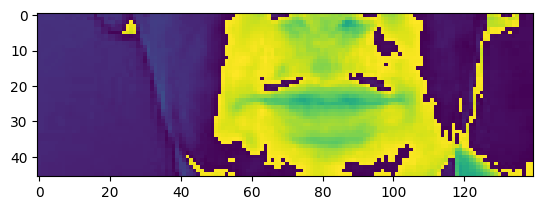

In [32]:
plt.imshow(val[0][0][35])

In [33]:
chars = num_to_char(tf.convert_to_tensor(val[1][0]))
tf.strings.reduce_join(chars).numpy().decode('utf-8')

'set red with i three soon'

In [34]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [35]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [36]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 75, 46, 140, 128)  3584      
_________________________________________________________________
activation (Activation)      (None, 75, 46, 140, 128)  0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 75, 23, 70, 128)   0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 75, 23, 70, 256)   884992    
_________________________________________________________________
activation_1 (Activation)    (None, 75, 23, 70, 256)   0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 75, 11, 35, 256)   0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 75, 11, 35, 75)    5

In [38]:
yhat = model.predict(val[0])

In [39]:
tf.argmax(yhat[0],axis=1)

<tf.Tensor: shape=(75,), dtype=int64, numpy=
array([30,  0,  0,  0, 30, 30, 30, 30, 30, 30, 30, 29, 29, 29, 29, 29, 29,
       29, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28,
       28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28,
       28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28,
       28, 29, 29, 29, 29, 29, 29], dtype=int64)>

In [40]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'11111111!!!!!!!???????????????????????????????????????????????????!!!!!!'>

In [41]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'11111111!!!!!!!???????????????????????????????????????????????????!!!!!!'>

In [42]:
model.input_shape

(None, 75, 46, 140, 1)

In [43]:
model.output_shape

(None, 75, 41)

In [44]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [45]:
def CTCLoss(y_true, y_pred):
    y_pred = tf.cast(y_pred, tf.float32)  # Ensure float32 for CTC
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [46]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        yhat = yhat.astype('float32')
        # sequence_length must match batch size
        seq_len = [yhat.shape[1]] * yhat.shape[0]
        decoded = tf.keras.backend.ctc_decode(yhat, seq_len, greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [47]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [48]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True) 

In [49]:
schedule_callback = LearningRateScheduler(scheduler)

In [50]:
example_callback = ProduceExample(test)

In [51]:
model.fit(train, validation_data = test, epochs = 100 , callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/100
450/450 [==============================] - 717s 1s/step - loss: 89.5581 - val_loss: 72.4586
Original: lay blue with e five soon
Prediction: le e e e e 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 2/100
450/450 [==============================] - 578s 1s/step - loss: 72.4287 - val_loss: 66.9978
Original: lay green with g two now
Prediction: la e e e e ea
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 3/100
450/450 [==============================] - 535s 1s/step - loss: 69.1865 - val_loss: 64.1071
Original: lay red in y zero now
Prediction: la e e e e oa
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 4/100
450/450 [==============================] - 546s 1s/step - loss: 66.2475 - val_loss: 61.4498
Original: set red in n four now
Prediction: la e e t e ao
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [63]:
model.save("Lip Read.h5")

In [64]:
url = "https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y"
output = "checkpoints.zip"
gdown.download(url, output, quiet = False)
gdown.extractall("checkpoints.zip","models")

Downloading...
From (original): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
From (redirected): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y&confirm=t&uuid=31506977-9ae6-4ce6-b088-5406666be288
To: D:\Proj\Lip read\checkpoints.zip
100%|█████████████████████████████████████████████████████████████████████████████| 94.5M/94.5M [00:09<00:00, 10.5MB/s]


['models\\checkpoint.index',
 'models\\__MACOSX/._checkpoint.index',
 'models\\checkpoint.data-00000-of-00001',
 'models\\__MACOSX/._checkpoint.data-00000-of-00001',
 'models\\checkpoint',
 'models\\__MACOSX/._checkpoint']

In [66]:
model.load_weights("models/checkpoint")

In [85]:
test_data = test.as_numpy_iterator()

sample = test_data.next()
yhat = model.predict(sample[0])
yhat = yhat.astype('float32')  # Ensure float32 for ctc_decode

# input_length must match batch size
input_length = [yhat.shape[1]] * yhat.shape[0]

decoded = tf.keras.backend.ctc_decode(yhat, input_length=input_length, greedy=True)[0][0].numpy()

for x in range(len(yhat)):
    print('Original:', tf.strings.reduce_join(num_to_char(sample[1][x])).numpy().decode('utf-8'))
    print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
    print('~'*100)

Original: lay white in y six now
Prediction: lay white in y six now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
